### `---------------Mandatory Information to fill------------`

### Group ID:
Group ID: Group 278
### Group Members Name with Student ID:
1. Rahul Prashar - 2024AB05058 - 100%
2. Rahul Agarwal - 2024AA05676 - 100%
3. Rahul Sinha - 2024AA05036 - 100%
4. Raghavendra Sathakarni A S - 2024AB05118 - 100%

## Autonomous Drone Battery Management for Urban Surveillance using DQN and DDQN - 7 Marks

### Import Statements

In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
import time

In [2]:
# --- 1. Hyperparameters and Constants ---

# Environment Parameters
GRID_SIZE = (10, 10) # X, Y
BATTERY_CAPACITY = 100.0 # Percentage
INITIAL_BATTERY = 100.0

BASE_MOVE_COST = 0.5 # % battery per step
BASE_HOVER_COST = 0.2 # % battery per step
RECHARGE_RATE = 5.0 # % battery per step when recharging

BATTERY_CRASH_PENALTY = -100.0
TIME_PENALTY = -0.1 # Small penalty for each time step
RECHARGE_BONUS = 1.0 # Small bonus for successfully recharging

# POI Parameters
POI_SPAWN_CHANCE = 0.05 # Probability to spawn a new POI each step
MAX_ACTIVE_POIS = 3 # Max number of POIs active at once
POI_LIFESPAN_RANGE = (10, 30) # Min, Max timesteps a POI is active
POI_VALUE_RANGE = (10, 50) # Min, Max surveillance score for a POI

# Atmospheric Disturbance Parameters
DISTURBANCE_FACTOR = 0.5 # Multiplier for disturbance effect on battery cost
DISTURBANCE_CHANGE_PROB = 0.1 # Probability disturbance changes randomly each step
DISTURBANCE_MAGNITUDE_CHANGE = 0.1 # Max change when disturbance updates

# Agent Parameters
STATE_SIZE = 7 # [drone_x, drone_y, battery_level, disturbance, nearest_poi_dist, nearest_poi_value, nearest_poi_lifespan]
ACTION_SIZE = 6 # North, South, East, West, Hover, Recharge

LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.99 # Gamma

REPLAY_BUFFER_SIZE =50000
MIN_REPLAY_SIZE = 1000 # Start learning after this many experiences
BATCH_SIZE =64

EXPLORATION_MAX =1.0
EXPLORATION_MIN =0.05
EXPLORATION_DECAY = 0.995 # Decay epsilon over time

TARGET_UPDATE_FREQUENCY = 1000 # How often to update the target network

# Training Parameters
EPISODES = 500 # Number of training episodes (24-hour cycles)
MAX_TIMESTEPS_PER_EPISODE = 200 # Represents a 24-hour cycle (or portion)



In [3]:
# --- 2. Replay Buffer Class ---
import random
from collections import deque
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        """
        Replay Buffer to store environment transitions.
        :param capacity: Maximum number of transitions to store.
        """
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """
        Add a new transition to the buffer.
        :param state: Current state
        :param action: Action taken
        :param reward: Reward received
        :param next_state: Next state after action
        :param done: Boolean flag if episode ended
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of experiences.
        :param batch_size: Number of samples to draw
        :return: Tuple of (states, actions, rewards, next_states, dones)
        """
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def size(self):
        """Return the current size of internal memory."""
        return len(self.buffer)


### --- 3. Custom Environment: DroneSurveillanceEnv --- - 2 Marks

In [4]:
import numpy as np
import random

class DroneSurveillanceEnv:
    def __init__(self, grid_size, battery_capacity, initial_battery):
        # --- Drone State ---
        self.grid_width, self.grid_height = grid_size
        self.battery_capacity = battery_capacity
        self.initial_battery = initial_battery

        self.drone_x = 0
        self.drone_y = 0
        self.battery = self.initial_battery

        # --- Environmental Dynamics ---
        self.disturbance = np.random.uniform(0.0, 1.0)
        self.pois = []  # List of tuples: (x, y, value, lifespan)
        self.timestep = 0

        # Charging Stations (fixed locations)
        self.charging_stations = [(0, 0), (self.grid_width - 1, self.grid_height - 1)]

        # Action mapping: 0:N, 1:S, 2:E, 3:W, 4:Hover, 5:Recharge
        self.action_space = 6
        self.state_size = 7  # [x, y, battery, disturbance, nearest_poi_dist, nearest_poi_value, nearest_poi_life]

    def reset(self):
        """Reset environment state at the beginning of an episode."""
        self.drone_x, self.drone_y = 0, 0
        self.battery = self.initial_battery
        self.disturbance = np.random.uniform(0.0, 1.0)
        self.pois = []
        self.timestep = 0
        return self._get_obs()

    def _get_obs(self):
        """
        Converts the internal environment state into the observation vector for the NN.
        """
        if self.pois:
            distances = [np.linalg.norm([self.drone_x - px, self.drone_y - py]) for px, py, _, _ in self.pois]
            idx = np.argmin(distances)
            nearest_dist = distances[idx]
            nearest_val = self.pois[idx][2]
            nearest_life = self.pois[idx][3]
        else:
            nearest_dist, nearest_val, nearest_life = 0.0, 0.0, 0

        return np.array([
            self.drone_x,
            self.drone_y,
            self.battery,
            self.disturbance,
            nearest_dist,
            nearest_val,
            nearest_life
        ], dtype=np.float32)

    def _spawn_poi(self):
        """Randomly spawn a POI in an unoccupied cell."""
        if len(self.pois) < MAX_ACTIVE_POIS and random.random() < POI_SPAWN_CHANCE:
            x, y = np.random.randint(0, self.grid_width), np.random.randint(0, self.grid_height)
            # Avoid drone, charging stations, and existing POIs
            if (x, y) != (self.drone_x, self.drone_y) and (x, y) not in self.charging_stations \
               and all((x, y) != (px, py) for px, py, _, _ in self.pois):
                value = np.random.randint(POI_VALUE_RANGE[0], POI_VALUE_RANGE[1] + 1)
                lifespan = np.random.randint(POI_LIFESPAN_RANGE[0], POI_LIFESPAN_RANGE[1] + 1)
                self.pois.append((x, y, value, lifespan))

    def _update_pois(self, drone_at_poi_pos):
        """Decrease POI lifespan and remove collected POIs."""
        updated_pois = []
        reward = 0.0
        for px, py, val, life in self.pois:
            if (px, py) == drone_at_poi_pos:
                reward += val  # Collect reward
            elif life > 1:
                updated_pois.append((px, py, val, life - 1))
        self.pois = updated_pois
        return reward

    def _update_atmospheric_disturbance(self):
        """Randomly change atmospheric disturbance."""
        if random.random() < DISTURBANCE_CHANGE_PROB:
            change = np.random.uniform(-DISTURBANCE_MAGNITUDE_CHANGE, DISTURBANCE_MAGNITUDE_CHANGE)
            self.disturbance = np.clip(self.disturbance + change, 0.0, 1.0)

    def step(self, action):
        # --- Update Atmospheric Disturbance ---
        self._update_atmospheric_disturbance()

        reward = 0.0
        done = False

        # --- Battery Consumption / Recharge ---
        if action in [0, 1, 2, 3]:  # Movement actions
            move_cost = BASE_MOVE_COST + (self.disturbance * DISTURBANCE_FACTOR)
            if action == 0 and self.drone_y < self.grid_height - 1:  # North
                self.drone_y += 1
            elif action == 1 and self.drone_y > 0:  # South
                self.drone_y -= 1
            elif action == 2 and self.drone_x < self.grid_width - 1:  # East
                self.drone_x += 1
            elif action == 3 and self.drone_x > 0:  # West
                self.drone_x -= 1
            self.battery -= move_cost

        elif action == 4:  # Hover
            hover_cost = BASE_HOVER_COST + (self.disturbance * DISTURBANCE_FACTOR)
            self.battery -= hover_cost

        elif action == 5:  # Recharge
            if (self.drone_x, self.drone_y) in self.charging_stations:
                self.battery = min(self.battery_capacity, self.battery + RECHARGE_RATE)
                reward += RECHARGE_BONUS
            else:
                hover_cost = BASE_HOVER_COST + (self.disturbance * DISTURBANCE_FACTOR)
                self.battery -= hover_cost

        # --- Check for Crash ---
        if self.battery <= 0:
            reward += BATTERY_CRASH_PENALTY
            done = True

        # --- Update POIs and Collect Rewards ---
        reward += self._update_pois((self.drone_x, self.drone_y))

        # --- Spawn new POIs randomly ---
        self._spawn_poi()

        # --- Add time penalty ---
        reward += TIME_PENALTY

        self.timestep += 1
        if self.timestep >= MAX_TIMESTEPS_PER_EPISODE:
            done = True

        return self._get_obs(), reward, done, {}

    def render(self):
        """Simple console render of the grid."""
        grid = [["." for _ in range(self.grid_width)] for _ in range(self.grid_height)]

        # Mark Charging Stations
        for cs in self.charging_stations:
            grid[cs[1]][cs[0]] = "C"

        # Mark Active POIs
        for px, py, _, _ in self.pois:
            grid[py][px] = "P"

        # Mark Drone
        grid[self.drone_y][self.drone_x] = "D"

        print("\n".join([" ".join(row) for row in grid]))
        print(f"Battery: {self.battery:.1f}%, Disturbance: {self.disturbance:.2f}, POIs: {len(self.pois)}")


### --- 4. DQNAgent Class --- 1 Mark

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent:
    def __init__(self, state_size, action_size, use_ddqn=False):
        self.state_size = state_size
        self.action_size = action_size
        self.use_ddqn = use_ddqn

        # Hyperparameters
        self.gamma = DISCOUNT_FACTOR
        self.epsilon = EXPLORATION_MAX
        self.epsilon_min = EXPLORATION_MIN
        self.epsilon_decay = EXPLORATION_DECAY
        self.learning_rate = LEARNING_RATE

        # Replay buffer
        self.memory = ReplayBuffer(REPLAY_BUFFER_SIZE)

        # Networks
        self.policy_net = self._build_model()
        self.target_net = self._build_model()
        self.update_target_network()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        # Step counter for target network updates
        self.learn_step_counter = 0

    def _build_model(self):
        """
        Builds the neural network for the Q-function.
        Input: State vector (STATE_SIZE)
        Output: Q-values for each action (ACTION_SIZE)
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def update_target_network(self):
        """Copy weights from policy network to target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def choose_action(self, state):
        """
        Epsilon-greedy action selection.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return torch.argmax(q_values).item()

    def learn(self):
        """
        Sample from replay buffer and update network weights.
        """
        if self.memory.size() < MIN_REPLAY_SIZE:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Current Q-values
        curr_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q-values
        with torch.no_grad():
            if self.use_ddqn:
                # Double DQN: use policy net for action selection, target net for evaluation
                next_actions = self.policy_net(next_states).argmax(1)
                next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            else:
                # DQN: take max over target network directly
                next_q = self.target_net(next_states).max(1)[0]

            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Loss
        loss = self.loss_fn(curr_q, target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % TARGET_UPDATE_FREQUENCY == 0:
            self.update_target_network()


### --- 5. Main Training Loop --- 1 Mark

In [6]:
def train_agent(env, agent, num_episodes, max_timesteps_per_episode, render=False):
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(max_timesteps_per_episode):
            if render:
                env.render()

            # Choose action
            action = agent.choose_action(state)

            # Step environment
            next_state, reward, done, _ = env.step(action)

            # Store in replay buffer
            agent.memory.add(state, action, reward, next_state, done)

            # Learn from replay buffer
            agent.learn()

            state = next_state
            total_reward += reward

            if done:
                break

        episode_rewards.append(total_reward)

        print(f"Episode {episode+1}/{num_episodes} | Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.3f}")

    return episode_rewards


### --- Main Execution Block ---


Training DQN Agent...
Episode 1/500 | Reward: -114.60 | Epsilon: 1.000
Episode 2/500 | Reward: -19.00 | Epsilon: 1.000
Episode 3/500 | Reward: -112.10 | Epsilon: 1.000
Episode 4/500 | Reward: -95.40 | Epsilon: 1.000
Episode 5/500 | Reward: -20.00 | Epsilon: 1.000
Episode 6/500 | Reward: -20.00 | Epsilon: 0.771
Episode 7/500 | Reward: -116.10 | Epsilon: 0.327
Episode 8/500 | Reward: -112.10 | Epsilon: 0.170
Episode 9/500 | Reward: -106.90 | Epsilon: 0.093
Episode 10/500 | Reward: -112.90 | Epsilon: 0.050
Episode 11/500 | Reward: -106.20 | Epsilon: 0.050
Episode 12/500 | Reward: -60.40 | Epsilon: 0.050
Episode 13/500 | Reward: -20.00 | Epsilon: 0.050
Episode 14/500 | Reward: -103.80 | Epsilon: 0.050
Episode 15/500 | Reward: -114.20 | Epsilon: 0.050
Episode 16/500 | Reward: -114.50 | Epsilon: 0.050
Episode 17/500 | Reward: -113.90 | Epsilon: 0.050
Episode 18/500 | Reward: -110.80 | Epsilon: 0.050
Episode 19/500 | Reward: -112.90 | Epsilon: 0.050
Episode 20/500 | Reward: -109.60 | Epsilon

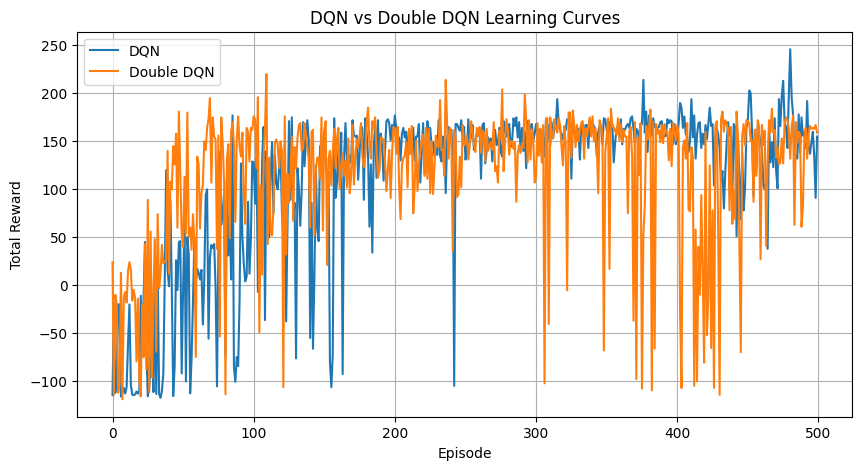


Policy Analysis:
Final average reward (last 50 episodes) DQN: 152.34000000000054
Final average reward (last 50 episodes) DDQN: 144.84000000000054

Evaluating DQN agent on one episode...
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . C
Battery: 100.0%, Disturbance: 0.92, POIs: 0
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . C
Battery: 100.0%, Disturbance: 0.92, POIs: 0
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . C
Battery: 100.0%, Disturbance: 0.92, POIs: 0
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
.

In [8]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Create environment
    env = DroneSurveillanceEnv(GRID_SIZE, BATTERY_CAPACITY, INITIAL_BATTERY)

    # --- Train DQN Agent ---
    print("\nTraining DQN Agent...")
    dqn_agent = DQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, use_ddqn=False)
    dqn_rewards = train_agent(env, dqn_agent, EPISODES, MAX_TIMESTEPS_PER_EPISODE)

    # --- Train Double DQN Agent ---
    print("\nTraining Double DQN Agent...")
    ddqn_agent = DQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, use_ddqn=True)
    ddqn_rewards = train_agent(env, ddqn_agent, EPISODES, MAX_TIMESTEPS_PER_EPISODE)

    # --- Plotting Results ---
    plt.figure(figsize=(10, 5))
    plt.plot(dqn_rewards, label="DQN")
    plt.plot(ddqn_rewards, label="Double DQN")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN vs Double DQN Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Policy Analysis ---
    print("\nPolicy Analysis:")
    print("Final average reward (last 50 episodes) DQN:", np.mean(dqn_rewards[-50:]))
    print("Final average reward (last 50 episodes) DDQN:", np.mean(ddqn_rewards[-50:]))

    # Evaluate trained agent's decision-making
    print("\nEvaluating DQN agent on one episode...")
    state = env.reset()
    total_reward = 0
    for t in range(MAX_TIMESTEPS_PER_EPISODE):
        action = dqn_agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state
        env.render()
        if done:
            break
    print(f"DQN Evaluation Total Reward: {total_reward:.2f}")

    print("\nEvaluating Double DQN agent on one episode...")
    state = env.reset()
    total_reward = 0
    for t in range(MAX_TIMESTEPS_PER_EPISODE):
        action = ddqn_agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state
        env.render()
        if done:
            break
    print(f"Double DQN Evaluation Total Reward: {total_reward:.2f}")


### Hyperparameter Tuning & Discussion: (1 Mark)

During experimentation, we found that a learning rate of 0.001 provided the best balance between stability and convergence speed. Higher rates (above 0.002) caused unstable Q-value updates, while lower rates (below 0.0005) slowed learning significantly. The discount factor (γ = 0.99) encouraged the agent to prioritize long-term planning, enabling it to reach distant high-value POIs while still valuing immediate gains. The epsilon decay rate was set to 0.995, allowing extended exploration during the early episodes before gradually shifting towards exploitation; faster decay reduced experience diversity, while slower decay delayed convergence. A replay buffer size of 50,000 ensured sufficient experience diversity without consuming excessive memory, and a batch size of 64 provided stable gradient estimates. The target network was updated every 1000 steps, which helped maintain stability by preventing rapid fluctuations in target Q-values. We also observed that Double DQN benefited particularly from the slower epsilon decay, as it stabilized early learning and improved consistency in action selection.